# Probablistic linear models using Pyro
August George, 2024, PNNL

## Linear regression

$y_i = m_i*x_i + b_i$

In [36]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal


pyro.set_rng_seed(42)

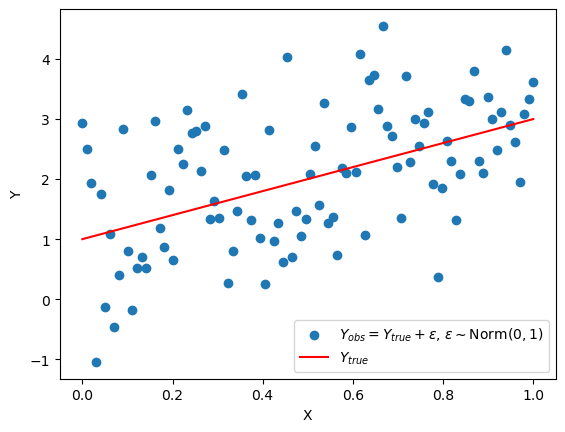

In [2]:
# simulate the data
true_intercept = 1
true_slope = 2
num_data_points = 100  
X_values = torch.linspace(0, 1, num_data_points)
Y_values = true_intercept + true_slope * X_values 
Y_obs_values = Y_values + torch.randn(num_data_points) 


plt.scatter(X_values, Y_obs_values, label=r'$Y_{obs} = Y_{true} + \epsilon$, $\epsilon \sim \text{Norm}(0,1)$')
plt.plot(X_values, Y_values, color='red', label=r'$Y_{true}$')
plt.ylabel('Y')
plt.xlabel('X')
plt.legend()
plt.show()

## Bayesian inference using NUTS

In [52]:
def linear_model(X_values, Y_values):
    intercept_prior = pyro.sample('intercept', dist.Normal(0, 10))
    slope_prior = pyro.sample('slope', dist.Normal(0, 10))
    noise_std_prior = pyro.sample('noise_std', dist.LogNormal(0, 1)) 
    mean_prediction = intercept_prior + slope_prior * X_values
    with pyro.plate('data', len(X_values)):
        pyro.sample('observations', dist.Normal(mean_prediction, noise_std_prior), obs=Y_values)

# MCMC inference
nuts_kernel = NUTS(linear_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X_values, Y_obs_values)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 1200/1200 [00:05, 201.61it/s, step size=4.22e-01, acc. prob=0.915]


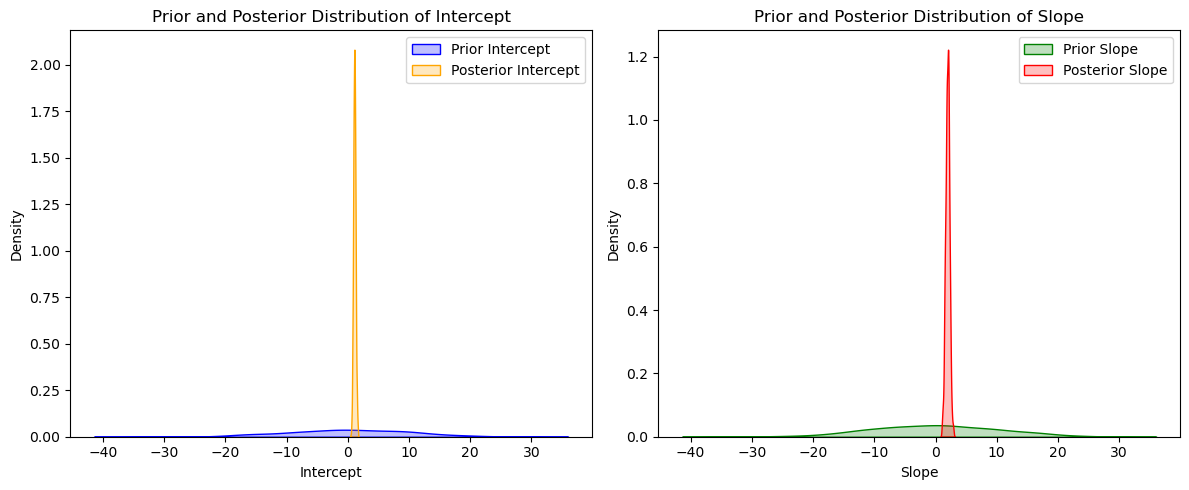

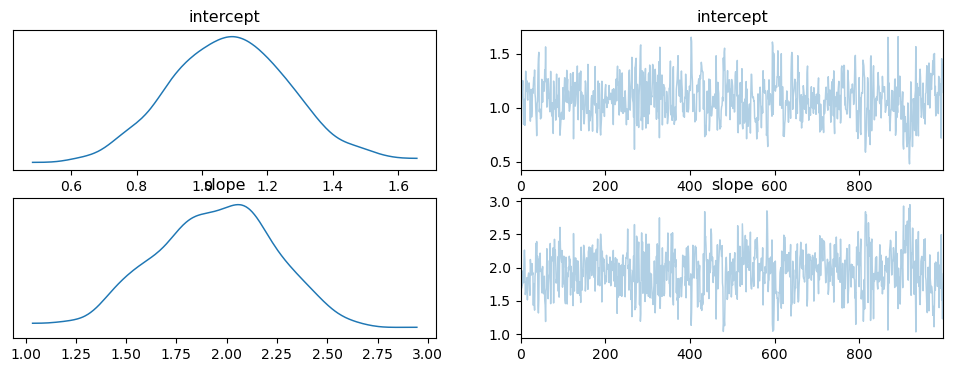

'MCMC intercept_mean = 1.0872195959091187, intercept_std = 0.18751227855682373'

'MCMC SVI slope_mean = 1.940335988998413, slope_std = 0.3211895227432251'

In [53]:
intercept_samples = posterior_samples["intercept"]
slope_samples = posterior_samples["slope"]
noise_std_samples = posterior_samples["noise_std"]
prior_intercept_samples = dist.Normal(0, 10).sample([1000])
prior_slope_samples = dist.Normal(0, 10).sample([1000])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(prior_intercept_samples.numpy(), fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples.numpy(), fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()
sns.kdeplot(prior_slope_samples.numpy(), fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples.numpy(), fill=True, color='red', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()

az.plot_trace({"intercept": intercept_samples, "slope": slope_samples})
plt.show()

intercept_mean = intercept_samples.mean().item()
intercept_std = intercept_samples.std().item()
slope_mean = slope_samples.mean().item()
slope_std = slope_samples.std().item()
noise_std_mean = noise_std_samples.mean().item()
noise_std_std = noise_std_samples.std().item()

display(f"MCMC intercept_mean = {intercept_mean}, intercept_std = {intercept_std}")
display(f"MCMC SVI slope_mean = {slope_mean}, slope_std = {slope_std}")

## Variational inference

Manual SVI Step 0 : loss = 207.190367937088
Manual SVI Step 100 : loss = 56.94725859165192
Manual SVI Step 200 : loss = 62.86453923583031
Manual SVI Step 300 : loss = 138.5568436384201
Manual SVI Step 400 : loss = 104.96514058113098
Manual SVI Step 500 : loss = 100.67325630784035
Manual SVI Step 600 : loss = 34.74439322948456
Manual SVI Step 700 : loss = 189.04808843135834
Manual SVI Step 800 : loss = 123.49612560868263
Manual SVI Step 900 : loss = 83.20759561657906


/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_83473/3685320967.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_std_loc = torch.tensor(pyro.param('noise_std_loc'))  # Convert to tensor
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_83473/3685320967.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_std_scale = torch.tensor(pyro.param('noise_std_scale'))


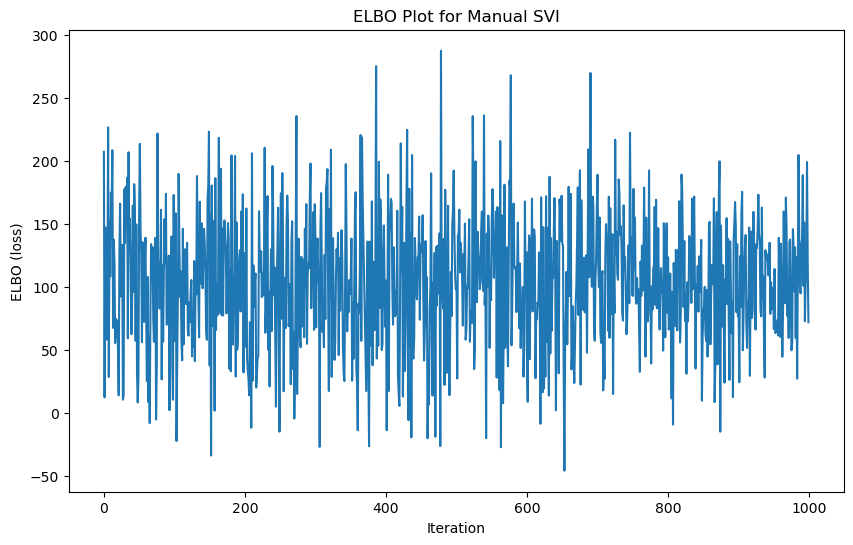

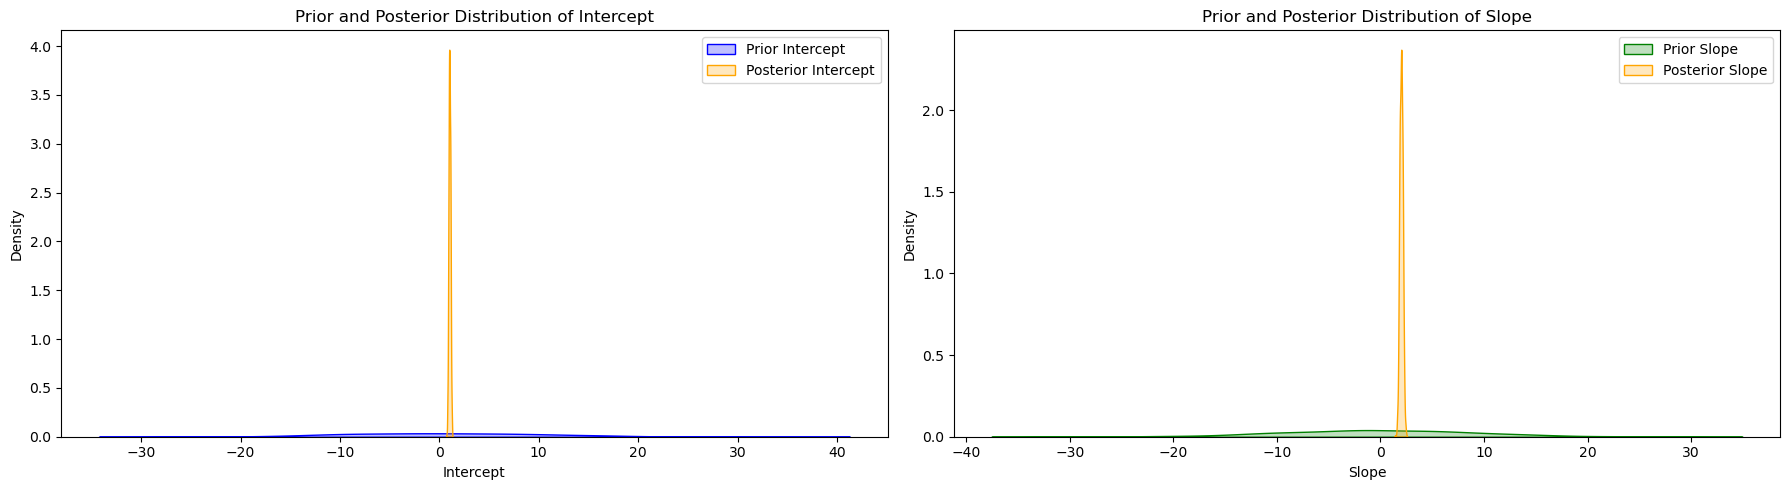

'Manual SVI intercept_mean = 1.0127270221710205, intercept_std = 0.08911702036857605'

'Manual SVI slope_mean = 1.991942286491394, slope_std = 0.16048404574394226'

In [55]:
def linear_model_guide(X_values, Y_values):
    intercept_loc = pyro.param('intercept_loc', torch.tensor(0.0))
    intercept_scale = pyro.param('intercept_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    slope_loc = pyro.param('slope_loc', torch.tensor(0.0))
    slope_scale = pyro.param('slope_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    noise_std_loc = pyro.param('noise_std_loc', torch.tensor(0.0))
    noise_std_scale = pyro.param('noise_std_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    pyro.sample('intercept', dist.Normal(intercept_loc, intercept_scale))
    pyro.sample('slope', dist.Normal(slope_loc, slope_scale))
    pyro.sample('noise_std', dist.LogNormal(noise_std_loc, noise_std_scale))


optimizer = optim.Adam({"lr": 0.01})
svi_manual = SVI(linear_model, linear_model_guide, optimizer, loss=Trace_ELBO())
num_iterations = 1000
elbo_values = []  
for step in range(num_iterations):
    loss = svi_manual.step(X_values, Y_values)
    elbo_values.append(loss)
    if step % 100 == 0:
        print(f"Manual SVI Step {step} : loss = {loss}")

intercept_loc = pyro.param('intercept_loc').item()
intercept_scale = pyro.param('intercept_scale').item()
slope_loc = pyro.param('slope_loc').item()
slope_scale = pyro.param('slope_scale').item()
noise_std_loc = torch.tensor(pyro.param('noise_std_loc'))  # Convert to tensor
noise_std_scale = torch.tensor(pyro.param('noise_std_scale'))  
noise_std_exp = torch.exp(noise_std_loc).item()

prior_intercept_samples = dist.Normal(0, 10).sample([1000]).numpy()
prior_slope_samples = dist.Normal(0, 10).sample([1000]).numpy()
intercept_samples = dist.Normal(intercept_loc, intercept_scale).sample([1000]).numpy()
slope_samples = dist.Normal(slope_loc, slope_scale).sample([1000]).numpy()

plt.figure(figsize=(10, 6))
plt.plot(elbo_values)
plt.xlabel('Iteration')
plt.ylabel('ELBO (loss)')
plt.title('ELBO Plot for Manual SVI')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(prior_intercept_samples, fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples, fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_slope_samples, fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples, fill=True, color='orange', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()


display(f"Manual SVI intercept_mean = {intercept_loc}, intercept_std = {intercept_scale}")
display(f"Manual SVI slope_mean = {slope_loc}, slope_std = {slope_scale}")

## Variational inference using an autoguide

Step 0 : loss = -560.1366373300552
Step 100 : loss = -548.3002926111221
Step 200 : loss = -563.2349275350571
Step 300 : loss = -545.7482409477234
Step 400 : loss = -573.8408383131027
Step 500 : loss = -562.7802468538284
Step 600 : loss = -571.7227860689163
Step 700 : loss = -569.4025040864944
Step 800 : loss = -584.3379517793655
Step 900 : loss = -483.3773046731949


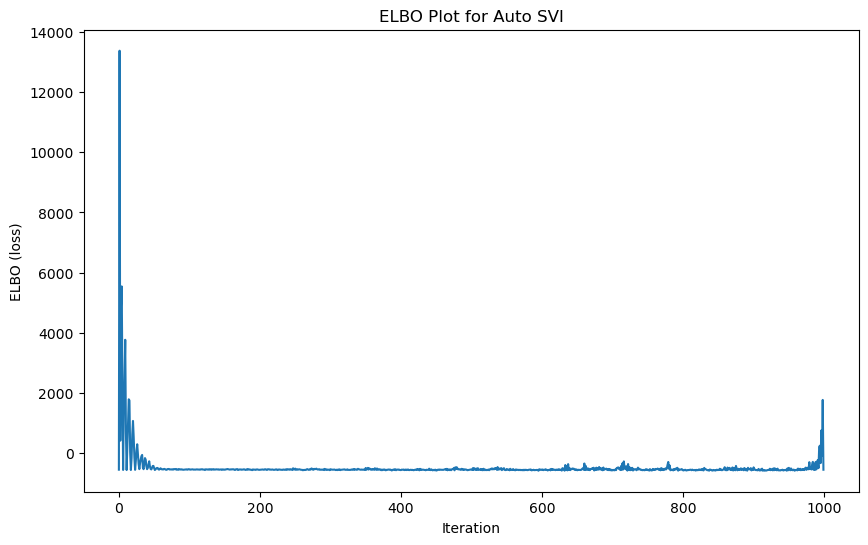

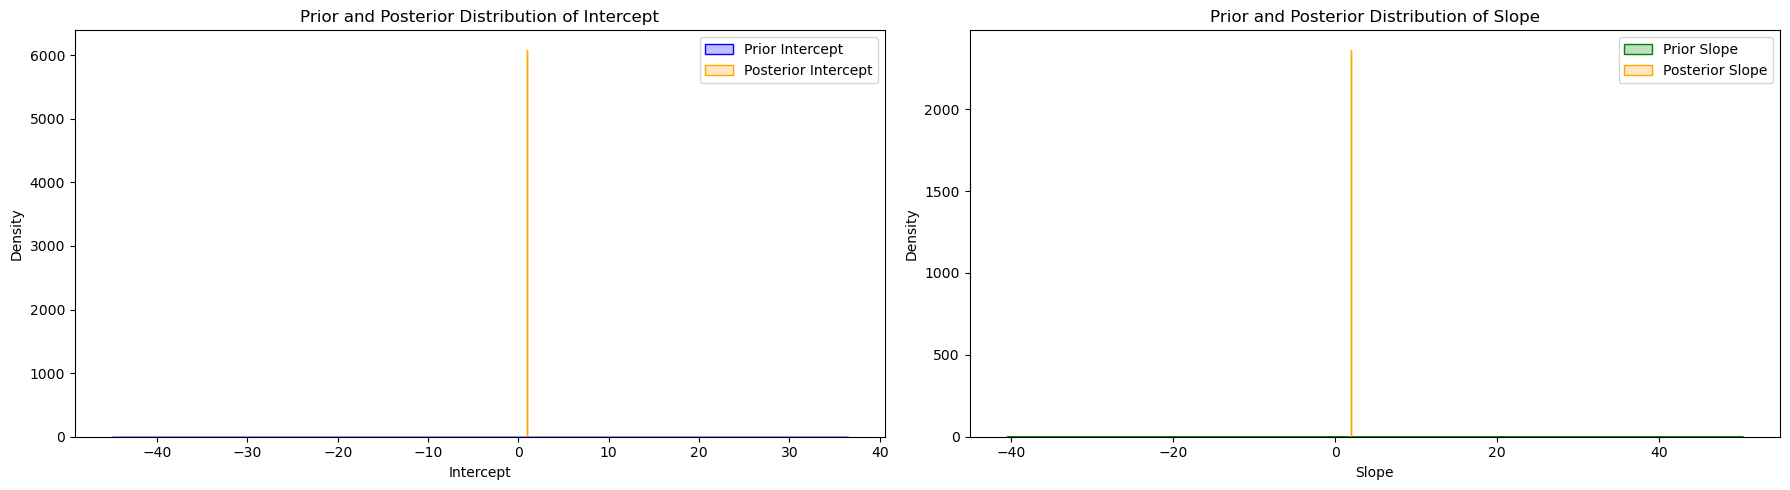

'Auto SVI intercept_mean = 0.9973955154418945, intercept_std = 6.24876847723499e-05'

'Auto SVI slope_mean = 1.9972968101501465, slope_std = 0.0001567896397318691'

'Auto SVI noise_std_mean = 1.0007286071777344, noise_std_std = 5.868030712008476e-05'

In [ ]:
auto_guide = AutoNormal(linear_model)
optimizer = optim.Adam({"lr": 0.01})
svi = SVI(linear_model, auto_guide, optimizer, loss=Trace_ELBO())

num_iterations = 1000
elbo_values = []  
for step in range(num_iterations):
    loss = svi.step(X_values, Y_values)
    elbo_values.append(loss)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

# get samples
prior_intercept_samples = dist.Normal(0, 10).sample([1000]).numpy()
prior_slope_samples = dist.Normal(0, 10).sample([1000]).numpy()
posterior_samples = [auto_guide() for _ in range(1000)]
posterior_samples = {k: torch.stack([s[k] for s in posterior_samples]) for k in posterior_samples[0]}
intercept_samples = posterior_samples['intercept'].detach().numpy()
slope_samples = posterior_samples['slope'].detach().numpy()
noise_std_samples = torch.exp(posterior_samples['noise_std']).detach().numpy()
intercept_mean = intercept_samples.mean()
intercept_std = intercept_samples.std()
slope_mean = slope_samples.mean()
slope_std = slope_samples.std()
noise_std_mean = noise_std_samples.mean()
noise_std_std = noise_std_samples.std()

# plot
plt.figure(figsize=(10, 6))
plt.plot(elbo_values)
plt.xlabel('Iteration')
plt.ylabel('ELBO (loss)')
plt.title('ELBO Plot for Auto SVI')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(prior_intercept_samples, fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples, fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_slope_samples, fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples, fill=True, color='orange', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()

plt.tight_layout()
plt.show()

display(f"Auto SVI intercept_mean = {intercept_mean}, intercept_std = {intercept_std}")
display(f"Auto SVI slope_mean = {slope_mean}, slope_std = {slope_std}")
display(f"Auto SVI noise_std_mean = {noise_std_mean}, noise_std_std = {noise_std_std}")


## linear structural causal model from gene regulatory network

A --> B

B --> C

D --| B

In [ ]:
# Number of samples
num_samples = 100

# Ground truth parameters
true_beta_A_B = 2.0
true_beta_D_B = -1.0
true_beta_B_C = 1.5

# Generate synthetic data
epsilon_A = torch.normal(0, 1, (num_samples,))
epsilon_D = torch.normal(0, 1, (num_samples,))
epsilon_B = torch.normal(0, 1, (num_samples,))
epsilon_C = torch.normal(0, 1, (num_samples,))

A = epsilon_A
D = epsilon_D
B = true_beta_A_B * A + true_beta_D_B * D + epsilon_B
C = true_beta_B_C * B + epsilon_C

# Print first few samples for inspection
display('Synthetic Data (first 5 samples):')
display('A =', A[:5])
display('D =', D[:5])
display('B =', B[:5])
display('C =', C[:5])



Synthetic Data (first 5 samples):
A = tensor([ 0.4962,  1.0366, -1.1833,  1.2373, -1.1257])
D = tensor([0.8030, 0.7662, 0.4832, 0.0101, 0.2334])
B = tensor([-1.8910,  3.5323, -3.1866,  0.4167, -3.4287])
C = tensor([-2.9867,  5.6278, -3.8755, -0.4777, -3.4588])


In [62]:
def gene_network_model(A, D, B, C, num_samples):
    # Priors for parameters
    beta_A_B = pyro.sample('beta_A_B', dist.Normal(0, 1))
    beta_D_B = pyro.sample('beta_D_B', dist.Normal(0, 1))
    beta_B_C = pyro.sample('beta_B_C', dist.Normal(0, 1))
    
    # Priors for epsilon (noise terms)
    epsilon_A = pyro.sample('epsilon_A', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_D = pyro.sample('epsilon_D', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_B = pyro.sample('epsilon_B', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_C = pyro.sample('epsilon_C', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    
    # Structural equations with uncertainty (noise terms)
    A_model = epsilon_A
    D_model = epsilon_D
    B_model = beta_A_B * A_model + beta_D_B * D_model + epsilon_B
    C_model = beta_B_C * B_model + epsilon_C
    
    # Define likelihoods for observed (real) data
    with pyro.plate('data', num_samples):
        pyro.sample('obs_A', dist.Normal(A_model, 1), obs=A)
        pyro.sample('obs_D', dist.Normal(D_model, 1), obs=D)
        pyro.sample('obs_B', dist.Normal(B_model, 1), obs=B)
        pyro.sample('obs_C', dist.Normal(C_model, 1), obs=C)

In [63]:
import pyro.infer.mcmc as mcmc
import pyro.infer.mcmc.api as mcmc_api

# Perform MCMC inference
pyro.clear_param_store()
kernel = mcmc_api.NUTS(lambda A, D, B, C: gene_network_model(A, D, B, C, num_samples), adapt_step_size=True)
mcmc_run = mcmc_api.MCMC(kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc_run.run(A, D, B, C)

# Extract samples
mcmc_samples = mcmc_run.get_samples()


Sample: 100%|██████████| 1200/1200 [00:52, 22.90it/s, step size=1.44e-01, acc. prob=0.873]


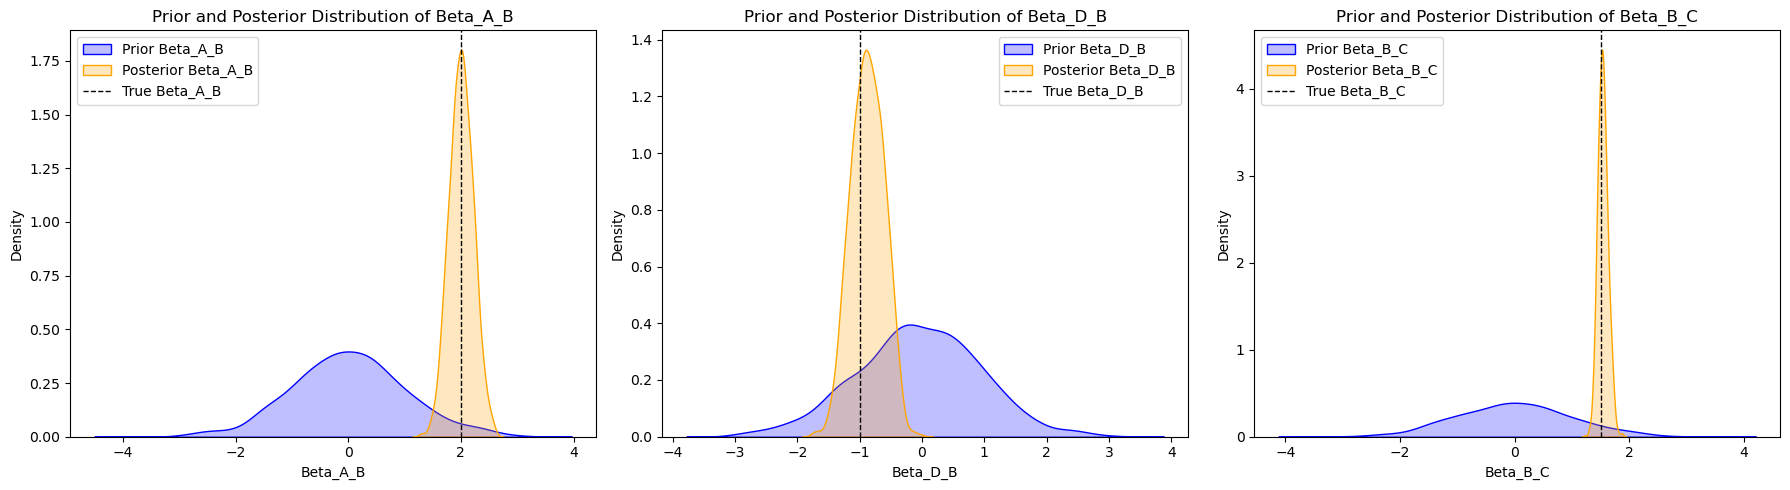

In [67]:
# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Posterior samples
posterior_beta_A_B = mcmc_samples['beta_A_B'].detach().numpy()
posterior_beta_D_B = mcmc_samples['beta_D_B'].detach().numpy()
posterior_beta_B_C = mcmc_samples['beta_B_C'].detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()


## SVI 

In [72]:
# Define the guide
guide = AutoNormal(gene_network_model)

# Set up the optimizer
optimizer = pyro.optim.Adam({"lr": 0.01})

# Set up the SVI object
svi = SVI(gene_network_model, guide, optimizer, loss=Trace_ELBO())

# Number of training steps
num_steps = 10000

# Run SVI
pyro.clear_param_store()
for step in range(num_steps):
    svi.step(A, D, B, C, num_samples)
    if step % 500 == 0:
        elbo = svi.evaluate_loss(A, D, B, C, num_samples)
        print(f'Step {step} - ELBO: {elbo}')


Step 0 - ELBO: 2157.9341430664062
Step 500 - ELBO: 762.7162170410156
Step 1000 - ELBO: 764.4209594726562
Step 1500 - ELBO: 772.3576049804688
Step 2000 - ELBO: 756.829345703125
Step 2500 - ELBO: 750.7062377929688
Step 3000 - ELBO: 762.6768188476562
Step 3500 - ELBO: 755.3085021972656
Step 4000 - ELBO: 753.1417541503906
Step 4500 - ELBO: 766.8055114746094
Step 5000 - ELBO: 773.8587341308594
Step 5500 - ELBO: 752.6968994140625
Step 6000 - ELBO: 753.0686645507812
Step 6500 - ELBO: 756.4848022460938
Step 7000 - ELBO: 757.0566101074219
Step 7500 - ELBO: 736.7340087890625
Step 8000 - ELBO: 726.434326171875
Step 8500 - ELBO: 781.2493591308594
Step 9000 - ELBO: 762.1195678710938
Step 9500 - ELBO: 761.7275695800781


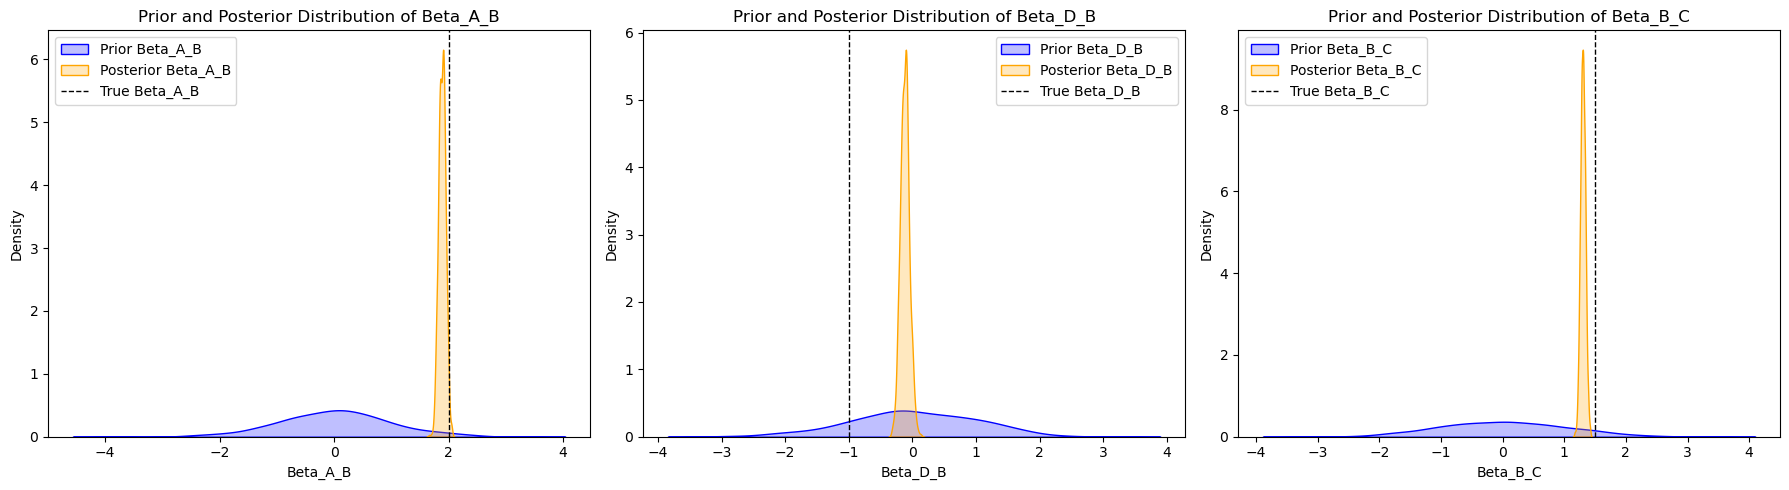

In [73]:
from pyro.infer import SVI, Trace_ELBO, Predictive

# Use Predictive to get posterior samples
predictive = Predictive(guide, num_samples=1000)
posterior_samples = predictive(A, D, B, C, num_samples)
posterior_beta_A_B = posterior_samples['beta_A_B'].detach().numpy()
posterior_beta_D_B = posterior_samples['beta_D_B'].detach().numpy()
posterior_beta_B_C = posterior_samples['beta_B_C'].detach().numpy()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()
